In [6]:
# For data analysis
import os
import numpy as np
import pandas as pd
from glob import glob

# For plotting
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import font_manager
from statannotations.Annotator import Annotator

# plot configuration
%config InlineBackend.figure_formats = ["svg"]
font_manager.fontManager.addfont(os.path.join("..", "assets", "Helvetica.ttf"))
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
pd.set_option("display.max_columns", None)
pd.set_option("show_dimensions", True)

In [7]:
# set path
# change root_path to your BIDS data path
root_path = os.path.join("F:", os.sep, "EGI_DATA", "EGI_BIDS")
data_path = os.path.join(root_path, "sourcedata", "rawdata")
tmp_beh_path = os.path.join("..", "data", "beh_data")
figure_path = os.path.join("..", "figures")
# set task name
foodtask = "foodchoice"
wordtask = "wordchoice"
imagetask = "imagechoice"
# animacy information
animacy_path = os.path.join("..", "assets", "animacy.csv")
association_path = os.path.join("..", "assets", "association.csv")
# figure path
food_fig_path = os.path.join(figure_path, foodtask)
if not os.path.exists(food_fig_path):
    os.makedirs(os.path.join(figure_path, foodtask))
word_fig_path = os.path.join(figure_path, wordtask)
if not os.path.exists(word_fig_path):
    os.makedirs(word_fig_path)
image_fig_path = os.path.join(figure_path, imagetask)
if not os.path.exists(image_fig_path):
    os.makedirs(image_fig_path)
# exclude subject id
exclude_sub = [1, 5, 19, 28]
# exclude_sub = []

In [8]:
animacy = pd.read_csv(animacy_path)
# get animacy dict of words
animacy_dict = animacy.set_index("word")["animacy"].to_dict()

# word/image correspondence
association = pd.read_csv(association_path)
img2word_dict = dict(zip(association["item_image"], association["item_word"]))

## Read data

In [9]:
stim_rec = {
    foodtask: ["image_right.started", "image_right_2.started"],
    wordtask: ["word_item.started", "word_item_2.started"],
    imagetask: ["image_item.started", "image_item_2.started"],
}
max_response_time = 3000
# load all behavior data
def summaryData(task):
    duration_list = []
    summary_df = None
    for beh_csv in glob(os.path.join(data_path, "*", "beh", f"*{task}*.csv")):
        sub = os.path.basename(beh_csv).split("_")[0].split("-")[1]
        if int(sub) in exclude_sub:
            continue
        df = pd.read_csv(beh_csv)
        duration_list.append(df["text.started"][321])
        df = df[1:321]
        df["sub"] = f"sub-{sub}"
        df["rt"] = df[stim_rec[task]].apply(lambda x: np.round((x[stim_rec[task][1]] - x[stim_rec[task][0]]) * 1000), axis=1)
        # remove outlier rt data
        df = df[df["rt"] <= max_response_time]
        # concatenate dataframes
        summary_df = pd.concat([summary_df, df], axis=0, ignore_index=True)
    print("{} task mean duration: {}".format(task, np.mean(duration_list) / 60))
    return summary_df

In [10]:
food_df = summaryData(foodtask)
word_df = summaryData(wordtask)
image_df = summaryData(imagetask)

foodchoice task mean duration: 27.226941667384395
wordchoice task mean duration: 24.99101703432716
imagechoice task mean duration: 25.806434127686984


## foodChoice

In [64]:
food_rt = food_df.groupby("sub")["rt"].mean()
print(f"food rt: M={food_rt.mean()}±{food_rt.std()}")

food rt: M=1295.1671644403275±223.5528935327539


### Fig. 4a

/home/haiyanwu/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_35773/876498499.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
No handles with labels found to put in legend.


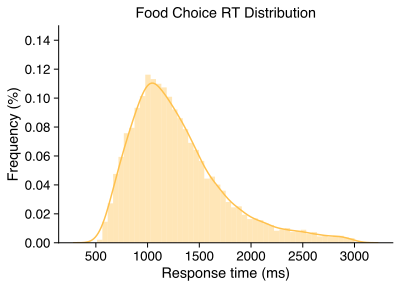

In [23]:
sns.set_context("paper", font_scale=1.5)
ax = sns.distplot(food_df["rt"], kde=True, kde_kws=dict(linewidth=1.5), color="#FFC14D")
ylabels = ['{:.2f}'.format(x * 100) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
# fig.set_yticks(ticks)
plt.ylim((0, 0.0015))
plt.xlabel("Response time (ms)")
plt.ylabel("Frequency (%)")
plt.legend(frameon=False)
plt.title("Food Choice RT Distribution", y=1.01)
plt.savefig("../figures/foodchoice/rt.svg", bbox_inches="tight")

## imageChoice

In [ ]:
# rename option
for option in ["option_left", "option_right"]:
    image_df[option] = image_df[option].map({"有生命": "animate", "无生命": "inanimate"})
# rename mouse.clicked_name columns
image_df["mouse.clicked_name"] = image_df["mouse.clicked_name"].map({"rect_left": "left", "rect_right": "right"})
image_df.rename(columns={"mouse.clicked_name":"side", "images.thisN":"trialN"}, inplace=True)

In [ ]:
# get animacy of image
image_df["animacy"] = image_df["item"].apply(lambda x: x.split("/")[0])
image_df["animacy"] = image_df["animacy"].map({"animate": "animate", "non-animate": "inanimate"})
# get mouse response
image_df["response"] = image_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
image_df["correct"] = image_df.apply(lambda x: x["animacy"] == x["response"], axis=1)
# replace image path with corresponding word
image_df["item"] = image_df["item"].map(img2word_dict)
# store stim type
image_df["stimuli"] = "image"
# reserve correct trials
image_df_corr = image_df[image_df["correct"] == True]

In [ ]:
# difference test
# rt
image_animate_rt = image_df_corr[image_df_corr["animacy"] == "animate"].groupby("sub")["rt"].mean()
image_inanimate_rt = image_df_corr[image_df_corr["animacy"] == "inanimate"].groupby("sub")["rt"].mean()
image_rt_t, image_rt_p = stats.ttest_rel(image_animate_rt, image_inanimate_rt)
print(f"image rt: M(animate)={image_animate_rt.mean()}±{image_animate_rt.std()}, M(inanimate)={image_inanimate_rt.mean()}±{image_inanimate_rt.std()}, T({np.unique(image_df['sub']).shape[0] - 1})={image_rt_t}, p={image_rt_p}")
# acc
image_animate_acc = image_df[image_df["animacy"] == "animate"].groupby("sub")["correct"].mean()
image_inanimate_acc = image_df[image_df["animacy"] == "inanimate"].groupby("sub")["correct"].mean()
image_acc_t, image_acc_p = stats.ttest_rel(image_animate_acc, image_inanimate_acc)
print(f"image acc: M(animate)={image_animate_acc.mean()}±{image_animate_acc.std()}, M(inanimate)={image_inanimate_acc.mean()}±{image_inanimate_acc.std()}, T({np.unique(image_df['sub']).shape[0] - 1})={image_acc_t}, p={image_acc_p}")

image rt: M(animate)=1239.5386931197745±210.7341097948826, M(inanimate)=1284.7762796712705±224.10042788300214, T(26)=-4.060112455714305, p=0.0003996107966712233
image acc: M(animate)=0.9917719167792207±0.011616727828293606, M(inanimate)=0.9514162589427585±0.05651757692931655, T(26)=3.6016035538794062, p=0.001309179745756344


### imageChoice RT (Fig. 4b)

/home/haiyanwu/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/haiyanwu/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_35773/2877924438.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


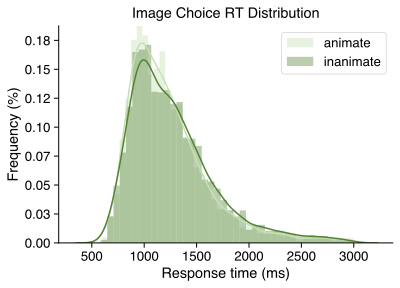

In [ ]:
# RT: animate/non-animate
sns.set_context("paper", font_scale=1.5)
ax = sns.distplot(image_df_corr[image_df_corr["animacy"] == "animate"]["rt"], color="#C5E0B4", kde=True, kde_kws=dict(linewidth=1.5), label="animate")
sns.distplot(image_df_corr[image_df_corr["animacy"] == "inanimate"]["rt"], color="#548235", kde=True, kde_kws=dict(linewidth=1.5), label="inanimate")
ylabels = ['{:.2f}'.format(x * 100) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.legend()
plt.ylim((0, 0.0015))
plt.xlabel("Response time (ms)")
plt.ylabel("Frequency (%)")
plt.title("Image Choice RT Distribution", y=1.01)
plt.savefig(os.path.join(image_fig_path, "rt-animacy.svg"), bbox_inches="tight")

### imageChoice acc (Fig. 4d left)

In [ ]:
image_acc = image_df.groupby(["sub", "animacy"])["correct"].mean().reset_index()
image_acc["animacy"] = image_acc["animacy"].map({"animate": "Animate", "inanimate": "Inanimate"})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Animate vs. Inanimate: t-test paired samples, P_val:1.309e-03 t=3.602e+00


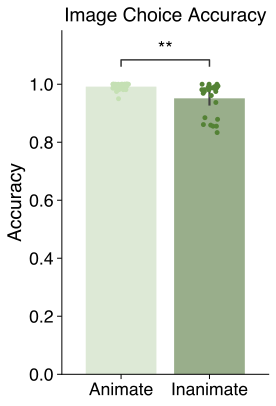

In [ ]:
sns.set_context("paper", font_scale=2)
order = ["Animate", "Inanimate"]
g = sns.catplot(x="animacy", y="correct", kind="bar", data=image_acc, palette=sns.color_palette(["#C5E0B4", "#548235"]), alpha=.6, height=6, aspect=.7)
sns.stripplot(x="animacy", y="correct", data=image_acc, palette=sns.color_palette(["#C5E0B4", "#548235"]))
g.ax.set_xmargin(0.15)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Image Choice Accuracy", y=1.01)
# annotation
annotator = Annotator(g.ax, pairs=[tuple(order)], data=image_acc, x="animacy", y="correct", order=order)
annotator.configure(test="t-test_paired", text_format="star", loc="inside")
annotator.apply_and_annotate()
plt.savefig(os.path.join(image_fig_path, "acc-animacy.svg"), bbox_inches="tight")

## wordChoice

In [24]:
# rename option
for option in ["option_left", "option_right"]:
    word_df[option] = word_df[option].map({"有生命":"animate", "无生命":"inanimate"})
# rename mouse.clicked_name columns
word_df["mouse.clicked_name"] = word_df["mouse.clicked_name"].map({"rect_left":"left", "rect_right":"right"})
word_df.rename(columns={"mouse.clicked_name":"side", "words.thisN":"trialN"}, inplace=True)

In [25]:
# get animacy of word
word_df["animacy"] = word_df["item"].apply(lambda x: animacy_dict[x])
# get mouse response
word_df["response"] = word_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
word_df["correct"] = word_df.apply(lambda x: x["animacy"] == x["response"], axis=1)
# store stim type
word_df["stimuli"] = "word"
# reserve correct trials
word_df_corr = word_df[word_df["correct"] == True]

In [60]:
# difference test
# rt
word_animate_rt = word_df_corr[word_df_corr["animacy"] == "animate"].groupby("sub")["rt"].mean()
word_inanimate_rt = word_df_corr[word_df_corr["animacy"] == "inanimate"].groupby("sub")["rt"].mean()
word_rt_t, word_rt_p = stats.ttest_rel(word_animate_rt, word_inanimate_rt)
print(f"word rt: M(animate)={word_animate_rt.mean()}±{word_animate_rt.std()}, M(inanimate)={word_inanimate_rt.mean()}±{word_inanimate_rt.std()}, T({np.unique(word_df_corr['sub']).shape[0] - 1})={word_rt_t}, p={word_rt_p}")
# acc
word_animate_acc = word_df[word_df["animacy"] == "animate"].groupby("sub")["correct"].mean()
word_inanimate_acc = word_df[word_df["animacy"] == "inanimate"].groupby("sub")["correct"].mean()
word_acc_t, word_acc_p = stats.ttest_rel(word_animate_acc, word_inanimate_acc)
print(f"word acc: M(animate)={word_animate_acc.mean()}±{word_animate_acc.std()}, M(inanimate)={word_inanimate_acc.mean()}±{word_inanimate_acc.std()}, T({np.unique(word_df_corr['sub']).shape[0] - 1})={word_acc_t}, p={word_acc_p}")

word rt: M(animate)=1214.489579494251±224.30971144899692, M(inanimate)=1266.9406027295781±222.869315344861, T(26)=-5.210466752726132, p=1.9299327976113335e-05
word acc: M(animate)=0.9885743453452173±0.010989454778245037, M(inanimate)=0.9488313146595208±0.05681448258134827, T(26)=3.5655264298371283, p=0.0014355706572222063


### wordChoice RT (Fig. 4c)

/home/haiyanwu/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/haiyanwu/miniconda3/envs/eeg/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_35773/3827002729.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


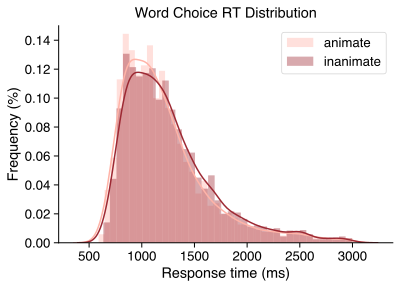

In [27]:
# RT: animate/non-animate
sns.set_context("paper", font_scale=1.5)
ax = sns.distplot(word_df_corr[word_df_corr["animacy"] == "animate"]["rt"], color="#FFB3A7", kde=True, kde_kws=dict(linewidth=1.5), label="animate")
sns.distplot(word_df_corr[word_df_corr["animacy"] == "inanimate"]["rt"], color="#9D2933", kde=True, kde_kws=dict(linewidth=1.5), label="inanimate")
ylabels = ['{:.2f}'.format(x * 100) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.legend()
plt.ylim((0, 0.0015))
plt.xlabel("Response time (ms)")
plt.ylabel("Frequency (%)")
plt.title("Word Choice RT Distribution", y=1.01)
plt.savefig(os.path.join(word_fig_path, "rt-animacy.svg"), bbox_inches="tight")

### wordChoice accuracy (Fig. 4d right)

In [29]:
word_acc = word_df.groupby(["sub", "animacy"])["correct"].mean().reset_index()
word_acc["animacy"] = word_acc["animacy"].map({"animate": "Animate", "inanimate": "Inanimate"})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Animate vs. Inanimate: t-test paired samples, P_val:1.436e-03 t=3.566e+00


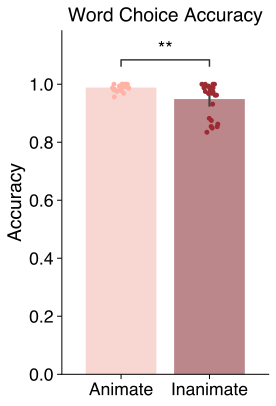

In [30]:
sns.set_context("paper", font_scale=2)
order = ["Animate", "Inanimate"]
g = sns.catplot(x="animacy", y="correct", kind="bar", data=word_acc, palette=sns.color_palette(["#FFB3A7", "#9D2933"]), alpha=.6, height=6, aspect=.7)
sns.stripplot(x="animacy", y="correct", data=word_acc, palette=sns.color_palette(["#FFB3A7", "#9D2933"]))
g.ax.set_xmargin(0.15)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Word Choice Accuracy", y=1.01)
# annotation
annotator = Annotator(g.ax, pairs=[tuple(order)], data=word_acc, x="animacy", y="correct", order=order)
annotator.configure(test="t-test_paired", text_format="star", loc="inside")
annotator.apply_and_annotate()
plt.savefig(os.path.join(word_fig_path, "acc-animacy.svg"), bbox_inches="tight")

## save data

In [40]:
# select columns
common_col = ["option_left", "option_right", "trialN", "xTrajectory", "yTrajectory", "tTrajectory", "side", "sub", "rt", "animacy", "response", "correct"]
word_image_col = ["item"] + common_col + ["stimuli"]
wi_col = ["item_word", "item_image"] + common_col
# save data
if not os.path.exists(tmp_beh_path):
    os.mkdir(tmp_beh_path)
food_df.to_csv(os.path.join(tmp_beh_path, f"{foodtask}.csv"), index=False)
word_df_corr[word_image_col].to_csv(os.path.join(tmp_beh_path, f"{wordtask}.csv"), index=False)
image_df_corr[word_image_col].to_csv(os.path.join(tmp_beh_path, f"{imagetask}.csv"), index=False)